In [123]:
import numpy as np
import emcee
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline
import pandas as pd
import corner
import corner
import time 
from scipy.stats import norm, laplace

from scipy.stats import anderson_ksamp, ks_2samp, shapiro
from scipy.optimize import curve_fit


In [134]:
# planet systems = Sys_{}_1e8.csv
def plot_hists( planet_systems,title=None):
    #try making more coherent plots
    ncol, nrow = 3,len(planet_systems)//3 +1
    #if len(planet_systems)%3 !=0:
    #    nrow+=1
    fig, axarr = plt.subplots(ncols=ncol,nrows=nrow)
    fig.set_size_inches((15, nrow*3))
    #axarr[0].histogram
    for jj , planet_sys in enumerate(planet_systems[:ncol*nrow]):
        #data =pd.read_csv("../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/"+planet_sys, index_col = 0)
        data=pd.read_csv("../../csvs/Res_3_feats/" + planet_sys, index_col=0)
        
        #print planet_sys, data.shape

        data = data[data["t"]<1e8]
        data["logt"] = np.log10(data["t"])
        name = planet_sys.split("_")[2]
        # make guassian
        mean, sigma =  info[info["ID"]==int(name)][["Mean", "Sigma"]].values[0]

        x = np.linspace(mean - sigma*4, mean+sigma*4, 100)
        rv = norm(loc = mean, scale = sigma)
        axarr[jj//ncol, jj%ncol ].plot(x, rv.pdf(x), linewidth = 4, color = "black")
        #color = graph[-1].get_color()
        data.hist("logt",  ax = axarr[jj//ncol, jj%ncol],  label = name + " Mean - " +str("{0:.3f}".format(mean)) + " Sigma - "+ str("{0:.3f}".format(sigma)), alpha = 0.7, normed = 1, color = "purple", edgecolor = "black", bins = 20)
        #create gaussian on top 
        axarr[jj//ncol, jj%ncol ].set_title(name + r': $\mu$=' +str("{0:.3f}".format(mean)) + r': $\sigma$='+ str("{0:.3f}".format(sigma)))
    plt.show()
    if title == None:
        plt.close(fig)
    else:
        fig.savefig("../Figures/MCMCFigures/"+title, bbox_extent = "tight")
    #plt.close(fig)

In [4]:
np.random.seed(0)
#First let's create a gaussian data

#file_path = "../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/"
file_path = "../../csvs/Res_3_feats/"
planet_systems = np.loadtxt(file_path+"order.txt", dtype = str)
#print planet_systems

# Then, define the probability distribution that you would like to sample.
def lnprob(p, vec):
    diff = vec-p[0]
    N = len(vec)
    #probs = 
    if p[1] <=0:
        return -np.inf#0
    try:
        probs = -0.5 * N * np.log(2. * np.pi) - N/2. * np.log(np.abs(p[1])**2) - 0.5 \
                                    * np.sum(( (vec - p[0]) / p[1] ) ** 2)
    except:
        probs = 0.00
    return probs
       
def log_prob_normed(mu, sigma, info):
    prob = -np.log(2*np.pi)/2. - np.log(sigma**2.)/2.-(1./(sigma**2.)/2./info.shape[0])*np.nansum((info-mu)**2.)
    #print 
    return prob
                                    
print planet_systems.shape

(317,)


In [12]:
np.random.seed(0)

#the delta times
delta_times = np.zeros((planet_systems.shape[0],3))

for jj, planet_sys in enumerate(planet_systems):
    try:
        times = pd.read_csv(file_path + planet_sys)
        delta_times[jj, 1:] = times["t"].values[:2]
        sys_id = planet_sys.split("_")[2]
        delta_times[jj, 0] = sys_id
    except:
        print "Did not work for {0}".format(planet_sys)
    
print(delta_times[:5, :])

[[0.00000000e+00 5.33062797e+03 9.37784115e+03]
 [1.00000000e+02 6.99705544e+04 6.97031351e+04]
 [1.01000000e+02 6.51055279e+05 5.06697334e+05]
 [1.02000000e+02 1.19833646e+07 1.38947086e+06]
 [1.03000000e+02 9.48782716e+02 4.00914304e+03]]


In [18]:
deltatimes=pd.DataFrame(delta_times, columns=["ID","t", "t_shadow"])
deltatimes= deltatimes.sort_values("ID")
deltatimes.tail()

,ID,t,t_shadow
245,391.0,2.815414e+04,5.142078e+04
246,393.0,7.103793e+05,3.221912e+05
247,394.0,2.527237e+06,3.198412e+06
249,395.0,8.670889e+03,7.556106e+03
250,399.0,2.319745e+06,3.153388e+06


In [17]:
deltatimes.to_csv(file_path + "/deltatimes.csv", index=False)

In [21]:
# trim by same criteria to see which are left
trimmed = deltatimes[(deltatimes["t"]<1e7) & (deltatimes["t"]>1e4)
                    & (deltatimes["t_shadow"]<1e7)& (deltatimes["t_shadow"]>1e4)]
trimmed.shape

(184, 3)

In [29]:
nwalkers = 20
ndim = 2
iterations = 1000

#store all the mean and  sigma in one large array, and then plot it all at the very end,
#since there are 48 systems, and 20*1000 samples per system, the final data array will be 960 000 long.
sample_size = nwalkers*iterations*planet_systems.shape[0]
all_walker_samples=np.zeros((int(sample_size), 4)) # add an extra clumn for the system index, and one for iteration number in for loop 
#mean_samples = np.zeros()
values = np.zeros((planet_systems.shape[0], 7), dtype=str)
covariences = np.zeros((planet_systems.shape[0], ndim, ndim))

In [37]:
planet_systems.shape
trimmed.shape
trimmed_ids = trimmed["ID"].values

In [31]:
info = pd.DataFrame(values, columns=["ID", "Probability", "Mean", "Sigma", "Mean_Error", "Sigma_Error", "Determinant"])
info.head()

for jj, planet_sys in enumerate(planet_systems):

    np.random.seed(jj)
    data =pd.read_csv(file_path+planet_sys, index_col = 0)
    data = data[data["t"]<1e8]
    #print data.shape
    data = np.log10(data["t"].values)
    sys_name = planet_sys.split("_")[2]
    print sys_name

    # Choose an initial set of positions for the walkers.
    p0 = [np.random.rand(ndim) for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data], a=5)
    
    # Run 200 steps as a burn-in.
    #print "Burning in ..."
    pos, prob, state = sampler.run_mcmc(p0, 200)

    # Reset the chain to remove the burn-in samples.
    sampler.reset()
    
    print "Running MCMC ...",
    start = time.time()
    pos, prob, state = sampler.run_mcmc(pos, iterations, rstate0=jj)
    end = time.time()
    print "Done at ...", (end - start), "seconds." 
    #af = sampler.acceptance_fraction
    #print "Mean acceptance fraction:", np.mean(af)
    

    #Determine the best mean and sigma
    maxprob_indice = np.argmax(prob)
    mean_fit, sigma_fit = pos[maxprob_indice]
    sigma_fit = np.abs(sigma_fit)
    #print "Estimated parameters: mean, sigma = %f, %f" % (mean_fit, sigma_fit)
    mean_samples = sampler.flatchain[:,0]
    sigma_samples = sampler.flatchain[:,1]
    mean_std = mean_samples.std()
    sigma_std =np.std(np.abs(sigma_samples) )
    covarience = np.cov([mean_samples, sigma_samples])
    print covarience
    determinant = np.linalg.det(covarience)
    print determinant
    covariences[jj, :, :] = covarience

    
    
    ##PLOT CORNER PLOT
    probability = -np.log(2*np.pi)/2. - np.log(sigma_fit**2.)/2.-(1./(sigma_fit**2.)/2./info.shape[0])*np.nansum((data-mean_fit)**2.)
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    

       
    #SAVE INFO OF INTEREST
    if np.exp(probability)>1:
        info.loc[jj] = [sys_name]+[np.inf]+[mean_fit, sigma_fit] + [np.inf]*3

    else:
        info.loc[jj] = [sys_name, np.exp(probability), mean_fit, sigma_fit, mean_std, sigma_std, determinant]
    print sys_name , probability, np.exp(probability),"\n"
    
info.head()

0
Running MCMC ... Done at ... 0.650088787079 seconds.
[[2.96413304e-04 1.04511084e-06]
 [1.04511084e-06 1.48971543e-04]]
4.4156054949765576e-08
0 -0.7366303396886675 0.4787243391125697 

100
Running MCMC ... Done at ... 0.668252944946 seconds.
[[ 6.40514714e-06 -1.56310058e-07]
 [-1.56310058e-07  3.34216721e-06]]
2.138263992861744e-11
100 1.1558911849473281 3.176853320215812 

101
Running MCMC ... Done at ... 0.669883966446 seconds.
[[6.27069117e-05 9.38404832e-07]
 [9.38404832e-07 2.97029143e-05]]
1.8616974226219597e-09
101 0.04242182257013727 1.0433344879765587 

102
Running MCMC ... Done at ... 0.708131074905 seconds.
[[9.16221572e-04 1.08917416e-05]
 [1.08917416e-05 4.37514044e-04]]
4.0074117557859677e-07
102 -1.307421420548759 0.2705167066356175 

103
Running MCMC ... Done at ... 0.699298858643 seconds.
[[ 1.96846106e-04 -4.21754545e-06]
 [-4.21754545e-06  1.05123182e-04]]
2.0675301414507228e-08
103 -0.5585251929860733 0.5720521084938697 

104
Running MCMC ... Done at ... 0.56957

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant
0,0,0.478724,3.78776,0.377825,0.0172162,0.0122051,4.41561e-08
1,100,inf,4.89002,0.0566576,inf,inf,inf
2,101,inf,5.87133,0.175308,inf,inf,inf
3,102,0.270517,6.01228,0.665493,0.0302684,0.0209163,4.00741e-07
4,103,0.572052,3.87191,0.31638,0.0140298,0.0102527,2.06753e-08


In [45]:
# save the plot
info = info.astype("float64")
info = info.sort_values("ID")
info.to_csv(file_path + "Gaussian_Fits_{0}.csv".format(info.shape[0]),index=False)

trimmed_ids = trimmed["ID"].values
print trimmed_ids[:4], type(trimmed_ids[0]), type(info.loc[0]["ID"])
#trim info to match systems in trimmed
trimmed_info = info.loc[ info["ID"].isin(trimmed_ids) ]
print trimmed_info.shape

[3. 4. 5. 8.] <type 'numpy.float64'> <type 'numpy.float64'>
(184, 7)


In [67]:
trimmed_info.head()

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant
222,3.0,0.591553,6.843058,0.306893,0.013710,0.009612,1.736264e-08
256,4.0,0.757357,5.687142,0.236672,0.010587,0.007466,6.239977e-09
267,5.0,0.391309,5.794232,0.458967,0.020387,0.014488,8.724085e-08
300,8.0,0.430769,5.888575,0.418128,0.018928,0.013127,6.174386e-08
39,13.0,0.715788,4.638226,0.250566,0.011497,0.008100,8.671577e-09


In [82]:
#print type(planet_systems)
trimmed_systems = [x for x in planet_systems if int(x.split("_")[2]) in trimmed_ids ]
print trimmed_ids[:4]
print trimmed_systems[:4]
print np.where(3 ==trimmed["ID"])
trimmed_systems[:9]

[3. 4. 5. 8.]
['Res_sys_100_500.csv', 'Res_sys_101_500.csv', 'Res_sys_108_500.csv', 'Res_sys_109_500.csv']
(array([0]),)


['Res_sys_100_500.csv',
 'Res_sys_101_500.csv',
 'Res_sys_108_500.csv',
 'Res_sys_109_500.csv',
 'Res_sys_113_500.csv',
 'Res_sys_115_500.csv',
 'Res_sys_119_500.csv',
 'Res_sys_121_500.csv',
 'Res_sys_122_500.csv']

In [94]:
#do tests for only valid systems within the instability time range cuts

sig_levels_and = np.zeros(len(trimmed))
sig_levels_kstest = np.zeros(len(trimmed))
sig_levels_shapiro = np.zeros(len(trimmed))
ids = np.zeros(len(trimmed))

for jj, planet_sys in enumerate(trimmed_systems):

    np.random.seed(jj)
    data =pd.read_csv(file_path +planet_sys, index_col = 0)
    data = data[data["t"]<1e8]
    data = np.log10(data["t"].values)
    #plt.hist(data)
    #plt.show()
    # id
    sys_name = float(planet_sys.split("_")[2])
    ids[jj] = sys_name
    index = np.where(sys_name==trimmed_info["ID"].values)[0][0]
    #print index, sys_name
    
    print(trimmed_info.iloc[index])
    # normal we want to match
    test = np.random.normal(loc=trimmed_info.iloc[index]["Mean"], scale=trimmed_info.iloc[index]["Sigma"], size = data.shape[0])
    #plt.hist(test)
    #plt.show()
    # anderson stats
    try:
        statistic, crit_val, sig_level =  anderson_ksamp([data, test])
    except:
        statistic, crit_val, sig_level = 0,0,0
    print sys_name
    print "And",  statistic,  crit_val, sig_level
    sig_levels_and[jj] = sig_level
    # sig level should be as low as possible, means it is rejected at anything higher
    # An approximate significance level at which the null hypothesis for the provided samples can be rejected.
    
    #ks test
    try:
        statistic, p_val = ks_2samp(data, test)
    except:
        statistic, p_val = 0,0
    sig_levels_kstest[jj] = p_val
    print "KS", statistic, p_val#, 
    
    #shapiro   
    #data  = norm.rvs(loc=1, scale=1, size=100)
    try:
        statistic, p_val = shapiro(data)
    except:
        statistic, p_val = 0,0
    sig_levels_shapiro[jj] = p_val
    print "SH", statistic, p_val
    #break

ID             100.000000
Probability           inf
Mean             4.890016
Sigma            0.056658
Mean_Error            inf
Sigma_Error           inf
Determinant           inf
Name: 1, dtype: float64
100.0
And 13.417977394659761 [0.325 1.226 1.961 2.718 3.752] 2.86920960046e-05
KS 0.144 5.3169784499192704e-05
SH 0.809592425823 7.67878230661e-24
ID             101.000000
Probability           inf
Mean             5.871326
Sigma            0.175308
Mean_Error            inf
Sigma_Error           inf
Determinant           inf
Name: 2, dtype: float64
101.0
And 3.414488514263197 [0.325 1.226 1.961 2.718 3.752] 0.0134045332658
KS 0.10799999999999998 0.00533810511163107
SH 0.972015857697 3.52677744786e-08
ID             1.080000e+02
Probability    4.985136e-01
Mean           6.590226e+00
Sigma          3.646328e-01
Mean_Error     1.648109e-02
Sigma_Error    1.140981e-02
Determinant    3.536476e-08
Name: 10, dtype: float64
108.0
And -0.12530841816855037 [0.325 1.226 1.961 2.718 3.752] 0.

In [95]:
scores = np.vstack([ ids, sig_levels_and, sig_levels_kstest, sig_levels_shapiro])
print scores.shape
scores = pd.DataFrame(scores.T, columns=["ID", "Anderson_P", "KS_P", "ShapiroW"] )
scores.head()

(4, 184)


,ID,Anderson_P,KS_P,ShapiroW
0,100.0,0.000029,0.000053,7.678782e-24
1,101.0,0.013405,0.005338,3.526777e-08
2,108.0,0.396757,0.403103,5.864905e-06
3,109.0,0.778484,0.761365,3.596655e-06
4,113.0,0.033488,0.055479,7.397713e-13


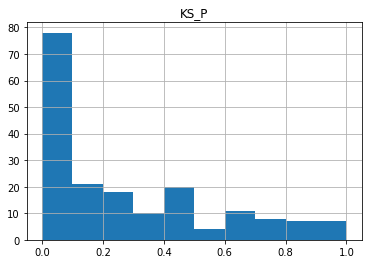

173


In [100]:
scores.hist("KS_P")
plt.show()
print len(np.where(scores["KS_P"]>1e-6)[0])
res_keep = scores[scores["KS_P"]>1e-6]
# interesting how we retain 173 out of 184 with the same cut
# we retain a significantly higher proportion, about 94%

['Res_sys_143_500.csv', 'Res_sys_165_500.csv', 'Res_sys_166_500.csv', 'Res_sys_334_500.csv', 'Res_sys_34_500.csv', 'Res_sys_347_500.csv', 'Res_sys_366_500.csv', 'Res_sys_49_500.csv', 'Res_sys_60_500.csv', 'Res_sys_89_500.csv', 'Res_sys_95_500.csv']


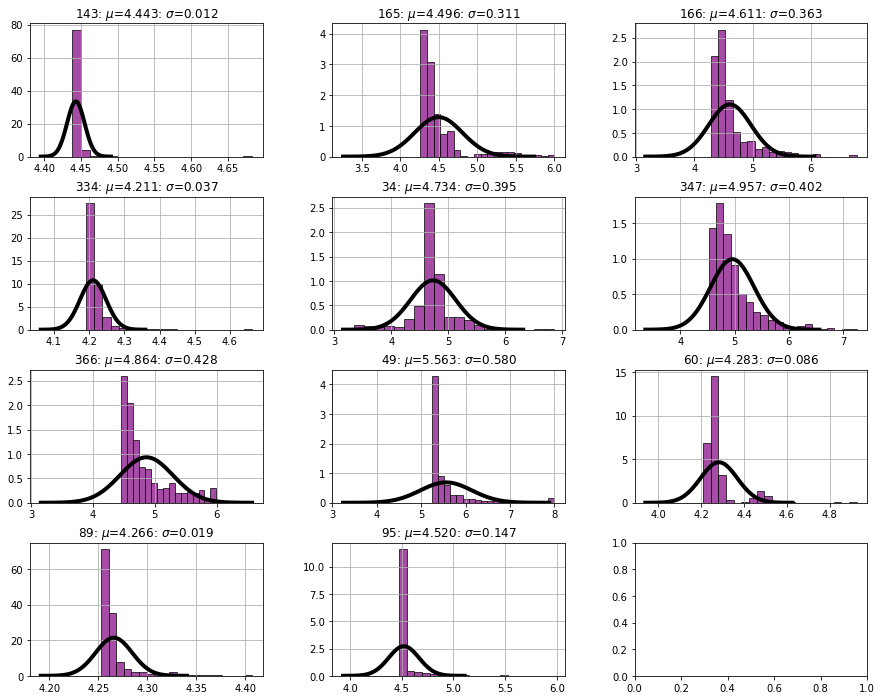

In [136]:
# plot which systems didnt make it
res_rejects = scores[scores["KS_P"]<1e-6]["ID"]
res_rejects_sys = ["Res_sys_{0}_500.csv".format(int(x))  for x in res_rejects]
print res_rejects_sys
plot_hists(res_rejects_sys)

['Res_sys_99_500.csv', 'Res_sys_188_500.csv', 'Res_sys_36_500.csv', 'Res_sys_243_500.csv']


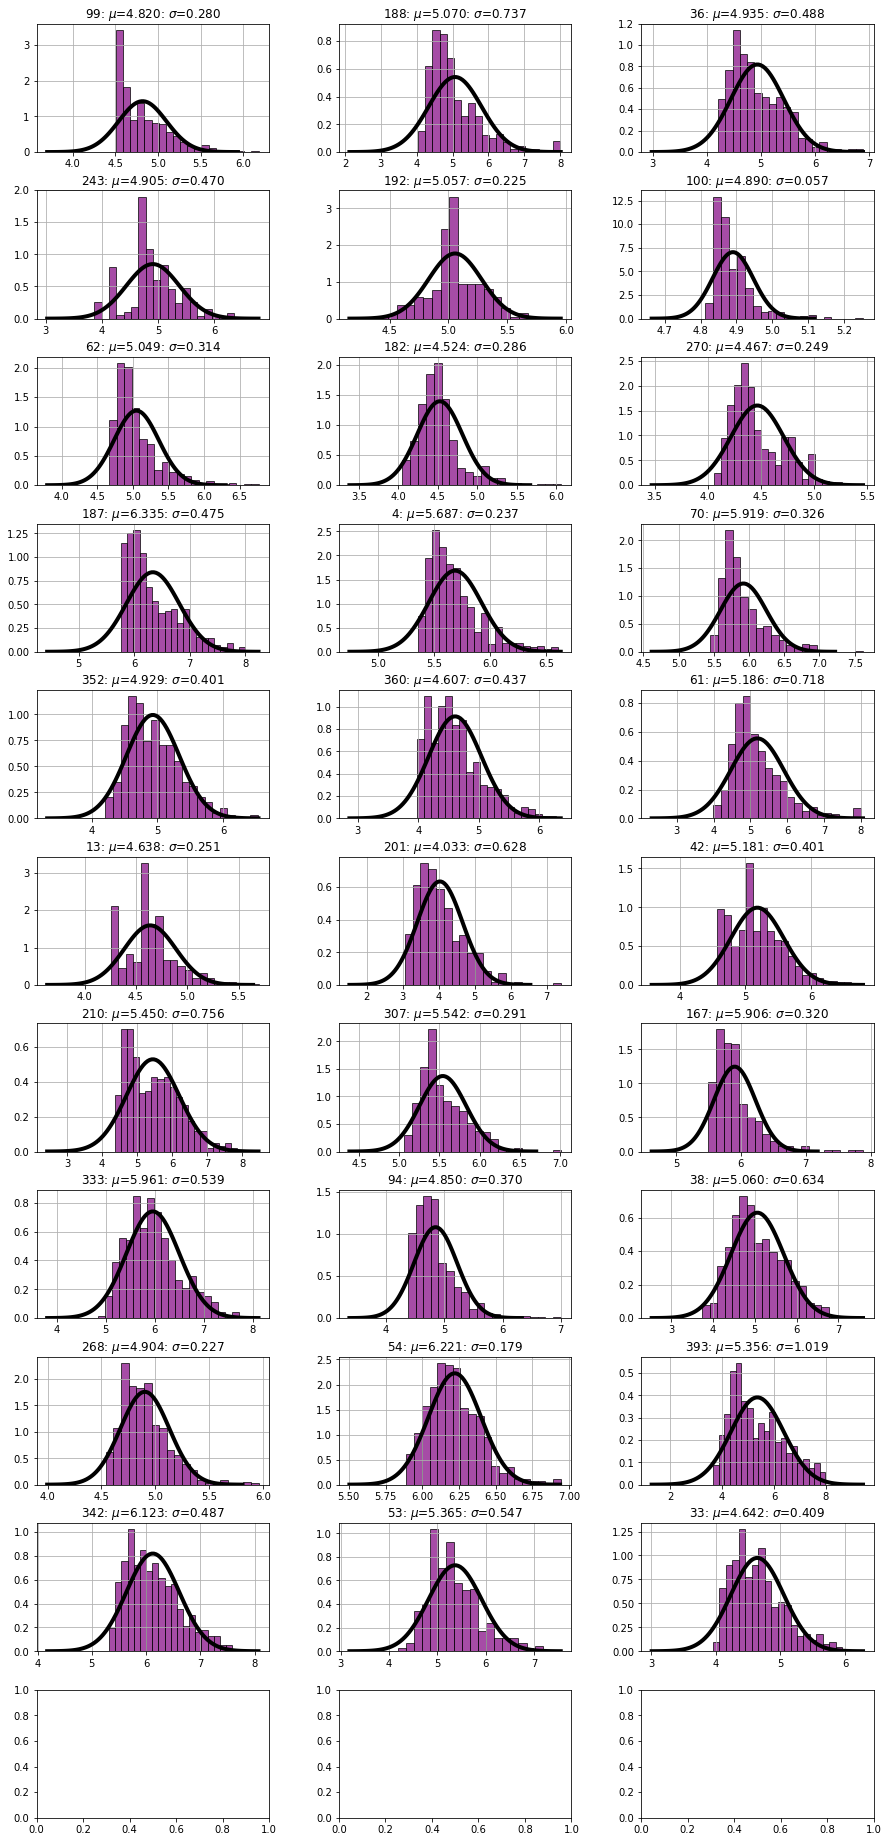

In [139]:
# look at the worst ones that were kept
# plot which systems didnt make it
res_keep_ordered= res_keep.sort_values("KS_P")
keep_ids = res_keep_ordered["ID"]
res_keep_sys = ["Res_sys_{0}_500.csv".format(int(x))  for x in keep_ids]
print res_keep_sys[:4]
plot_hists(res_keep_sys[:30])

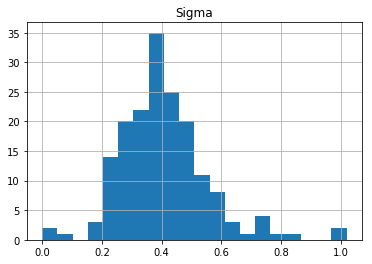

In [140]:
valid_gaus_params= trimmed_info[trimmed_info["ID"].isin((res_keep["ID"]).values)]
valid_gaus_params.hist("Sigma", bins = 20)
plt.show()

Average Sigma 0.4064755847130366 Std in Sigma 0.1474515630864684
('Max valid sigma', 1.0190649398313756)


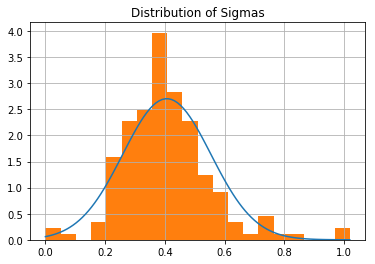

In [141]:
mu_fit, sig_fit =  norm.fit(valid_gaus_params["Sigma"].values)
print "Average Sigma", mu_fit, "Std in Sigma", sig_fit
#x, xmax = plt.xlim()
fig = plt.figure()
ax = fig.add_subplot("111")
x = np.linspace(0, valid_gaus_params["Sigma"].max(), 100)
prob_sig = norm.pdf(x, mu_fit, sig_fit)
plt.plot(x, prob_sig)
valid_gaus_params.hist("Sigma", normed = 1, ax = ax, bins = 20)
print("Max valid sigma", valid_gaus_params["Sigma"].max())
plt.title("Distribution of Sigmas")
plt.show()

In [114]:
from scipy.stats import norm
# p is the sigma distribution
# trimmed delta times
print trimmed.shape
#print prob_sig[:10]
#print prob_sig.sum()
norm_prob_sig = prob_sig/(prob_sig.sum())
print norm_prob_sig[-10:]
print x[:10]

(184, 3)
[5.57069217e-05 4.34452823e-05 3.37178274e-05 2.60411429e-05
 2.00144654e-05 1.53077530e-05 1.16509783e-05 8.82463676e-06
 6.65142625e-06 4.98903119e-06]
[0.         0.01029359 0.02058717 0.03088076 0.04117434 0.05146793
 0.06176151 0.0720551  0.08234868 0.09264227]


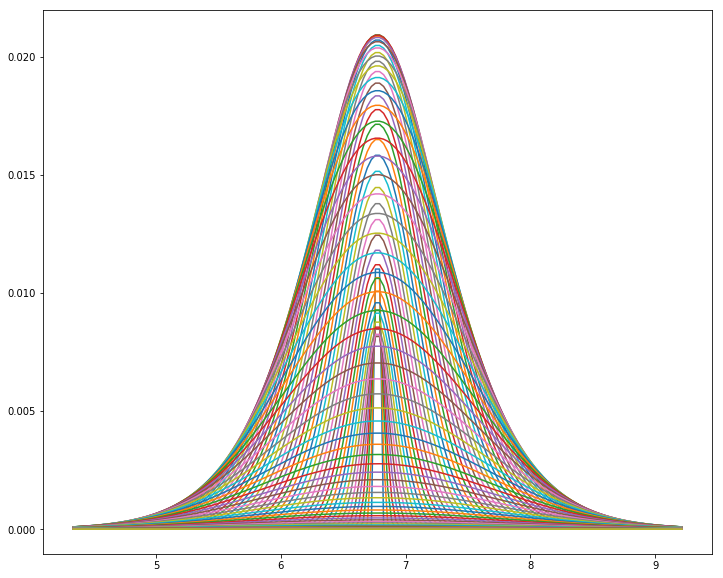

In [118]:
#Analytically over each of the mu;s, how to combine the sigmas?
#try with the first 100
trial = 10 #how many to test it with
max_sigma = mu_fit #the center, used to define bins
increments = 150 # how fine does the convoltion have to be?
#bins = np.linspace(0, 1.5, 20)

plt.figure(figsize=(12, 10))


total_y= np.zeros(increments)
for j in range(1,int(prob_sig.shape[0]), 1):
    fixed_sigma=x[j]
    t_sim = np.log10(trimmed["t"].values[0]) # take the first one
    #print t_sim
    # doesn't matter, the resulting shape will be the same regarless where you do it 
    bins = np.linspace(t_sim -6*max_sigma, t_sim +6*max_sigma, increments)
    final_y = norm.pdf(bins, t_sim, fixed_sigma*2**0.5)* norm_prob_sig[j]       
    total_y +=final_y
    plt.plot(bins, final_y )

end = time.time()
plt.show()


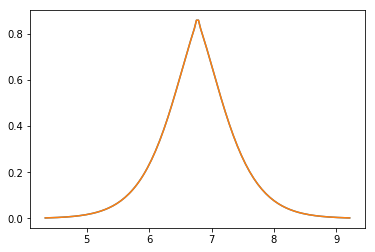

In [120]:
bins = np.linspace(t_sim -6*max_sigma, t_sim +6*max_sigma, increments)
plt.plot(bins, total_y)
width = (12*max_sigma)/(increments-1)
plt.show()
#print  width, bins[1] - bins[0]
#center, spread =laplace.fit(total_y)
#rv =laplace(loc = center, scale = spread)
#loc should be zero, since this should be symmetric about t = 0
# plt.plot(bins, rv.pdf(bins))
# NEed to do a least sqaures fit of a laplaec fit to this data

The laplace distribution has a mean of $\mu$, and a varience of $2b^2$.  P(x) = $\frac{1}{2b}exp(\frac{-|x-\mu|}{b})$

In [121]:
def laplace_fit(data, mean, spread):
    #data is your data
    #mean spread are the params you try to fit to the data
    return np.exp(-np.abs(data-mean)/spread)/2./spread

[-2.36287264e-06  5.20096240e-01]
[0.00359899 0.00510237]
('params', array([0.        , 0.52009624]))


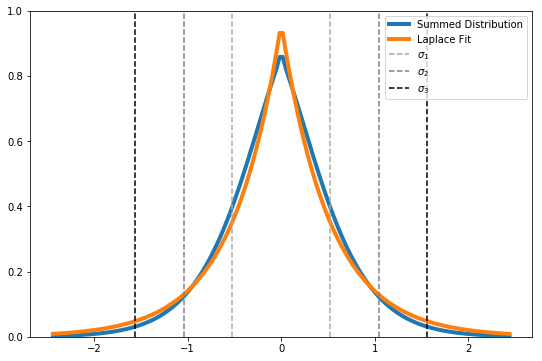

In [142]:
#function for optimizing the difference between total_Y(graph from)
#use the same x values,
plt.figure (figsize=(9, 6))
popt, pcov = curve_fit(laplace_fit, bins, total_y)
print popt
perr = np.sqrt(np.diag(pcov))
print perr

#set popt[0] to 0, since the center should be 0
# center y total as well
bins -= popt[0]
popt[0] = 0

plt.plot(bins, total_y, label = "Summed Distribution", linewidth = 4)
print("params", popt)


plt.plot(bins, laplace_fit(bins, *popt), label = "Laplace Fit", linewidth = 4)
#plt.legend()


colors = ["darkgrey","grey", "black"]
for i in range(1,4):
    plt.axvline(popt[0]+i*popt[1], ls= "dashed", label = "$\sigma_{0}$".format(i), color = colors[i-1])
    plt.axvline(popt[0]-i*popt[1], ls= "dashed", color = colors[i-1])
plt.legend()
plt.ylim([0,1])
plt.show()

need the 10000 data samples before the next part can be done, which is taking all the delta times within our cuts and plotting that distribution
